In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content
!mkdir -p datasets/wikiart

Mounted at /content/gdrive
/content


In [ ]:
!cp /content/gdrive/MyDrive/Work/BlogData/Datasets/WikiArt/wikiart.zip datasets
!cp /content/gdrive/MyDrive/Work/BlogData/Datasets/WikiArt/wikiart_csv.zip datasets

In [ ]:
!unzip datasets/wikiart.zip -d datasets/wikiart
!unzip datasets/wikiart_csv.zip -d datasets/wikiart_csv

Streaming output truncated to the last 5000 lines.
  inflating: datasets/wikiart/wikiart/Romanticism/john-trumbull_general-george-washington-resigning-his-commission-1817.jpg  
  inflating: datasets/wikiart/wikiart/Romanticism/karl-bodmer_cutoff-river-branch-of-the-wabash-plate-8-from-volume-1-of-travels-in-the-interior-of-north-1843.jpg  
  inflating: datasets/wikiart/wikiart/Romanticism/polychronis-lembesis_childs-with-rabbits-1879.jpg  
  inflating: datasets/wikiart/wikiart/Romanticism/cornelis-springer_the-herengracht-aan-de-amstel.jpg  
  inflating: datasets/wikiart/wikiart/Romanticism/sir-lawrence-alma-tadema_the-vintage-festival-1870.jpg  
  inflating: datasets/wikiart/wikiart/Romanticism/ivan-aivazovsky_the-gale-on-sea-is-over-1839.jpg  
  inflating: datasets/wikiart/wikiart/Romanticism/gustave-dore_the-destruction-of-leviathan.jpg  
  inflating: datasets/wikiart/wikiart/Romanticism/ivan-aivazovsky_view-of-the-big-cascade-in-petergof-and-the-great-palace-of-petergof-1837.jpg  


In [ ]:
!rm datasets/wikiart.zip
!rm datasets/wikiart_csv.zip

# 1. Data cleaning

In [ ]:
%cd datasets

In [3]:
import pandas as pd
import numpy as np
import yaml
import os

In [14]:

def read_class_txt(txt_file):
    # returns dictionary with key = id and value = label
    with open(txt_file) as f:
        lines = f.readlines()
        lines = [line.strip().split() for line in lines]
        classes_dict = dict(lines)
    return classes_dict 

In [15]:
path_to_class_info = "/content/datasets/wikiart_csv"
artist_class = read_class_txt(os.path.join(path_to_class_info, 'artist_class.txt'))
genre_class = read_class_txt(os.path.join(path_to_class_info, 'genre_class.txt'))
style_class = read_class_txt(os.path.join(path_to_class_info, 'style_class.txt'))

In [16]:
# change name because of data error
style_class['3']='Art_Nouveau_Modern'

In [17]:
# first model is going to be to classify style
style_class

{'0': 'Abstract_Expressionism',
 '1': 'Action_painting',
 '10': 'Fauvism',
 '11': 'High_Renaissance',
 '12': 'Impressionism',
 '13': 'Mannerism_Late_Renaissance',
 '14': 'Minimalism',
 '15': 'Naive_Art_Primitivism',
 '16': 'New_Realism',
 '17': 'Northern_Renaissance',
 '18': 'Pointillism',
 '19': 'Pop_Art',
 '2': 'Analytical_Cubism',
 '20': 'Post_Impressionism',
 '21': 'Realism',
 '22': 'Rococo',
 '23': 'Romanticism',
 '24': 'Symbolism',
 '25': 'Synthetic_Cubism',
 '26': 'Ukiyo_e',
 '3': 'Art_Nouveau_Modern',
 '4': 'Baroque',
 '5': 'Color_Field_Painting',
 '6': 'Contemporary_Realism',
 '7': 'Cubism',
 '8': 'Early_Renaissance',
 '9': 'Expressionism'}

In [ ]:
# for label_type in ['artist', 'genre', 'style']:
#     for subset in ['train', 'val']:
#         pd.Dataframe(label_type+"_"+subset+".csv")


# 2. Model 

In [4]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms as T
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

ImageFolder is structured like this:

```
# root/label/image.png
root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png
```
In our case:
```
wikiart
    wikiart
        train
            Abstract_Expressionism
                img1.jpg
            ...
        val
            Abstract_Expressionism
                imgX.jpg
            ...
```




In [ ]:

a = pd.read_csv("wikiart_csv/style_train.csv", header=None)
b = pd.read_csv("wikiart_csv/style_val.csv", header=None)
merged = a.append(b)
merged.dropna()
merged.to_csv("style.csv", header=None, index=False)
merged

In [ ]:
%cd /content/datasets/wikiart

In [5]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler

class WikiArtDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, header=None, names=['file_path','label'])
        self.img_dir = img_dir
        self.transform = transform
        self.class_names = style_class
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, img_path

In [ ]:
transform = nn.Sequential(
            T.Resize([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )


wikiart_dataset = WikiArtDataset(
    '../style.csv', 
    'wikiart',
    transform=transform
)

In [ ]:
wikiart_dataset[0][0].shape

In [ ]:
dataset_size = len(wikiart_dataset)
idxs = list(range(dataset_size))

val_split = 0.2
shuffle = True
batch_size = 12

split = int(np.floor(val_split * dataset_size))
if shuffle :
    np.random.seed(1)
    np.random.shuffle(idxs)
train_indices, val_indices = idxs[split:], idxs[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(wikiart_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(wikiart_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

dataloaders = {
    'train': train_loader,
    'val': validation_loader
}


dataset_sizes = {
    'train': len(train_indices),
    'val': len(val_indices)
}


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes, img_paths = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    try:

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels, img_paths in tqdm(dataloaders[phase]):
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            # backward + optimize only if in training phase
                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        # statistics
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
    except RuntimeError:
        print("Error loading image in one of these images:")
        print(next(iter(dataloaders[phase])))
        print(*img_paths, sep = "\n") 
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, img_paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} true: {} img path: {}'.format(wikiart_dataset.class_names[str(preds[j].item())], \
                                                             wikiart_dataset.class_names[str(labels[j].item())], \
                                                             img_paths[j]
                                                             )
                )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [25]:

model_ft = models.resnet18(pretrained=True, progress=True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(wikiart_dataset.class_names))

#continue from previoua best weights
model_ft.load_state_dict(torch.load('/content/gdrive/MyDrive/Work/BlogData/best_epoch21.pt'))

model_ft = model_ft.to(torch.device("cuda:0"))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------


100%|██████████| 5430/5430 [30:30<00:00,  2.97it/s]


train Loss: 0.2098 Acc: 0.9380


 98%|█████████▊| 1330/1358 [06:07<00:07,  3.61it/s]


Error loading image in one of these images:
[tensor([[[[ 1.4612,  1.4783,  1.4269,  ...,  1.4612,  1.4954,  1.4783],
          [ 1.3927,  1.4783,  1.4612,  ...,  1.4269,  1.4954,  1.5125],
          [ 1.3584,  1.4612,  1.4783,  ...,  1.4098,  1.4440,  1.4612],
          ...,
          [ 1.9235,  1.9920,  1.9920,  ...,  1.8379,  1.8379,  1.8037],
          [ 1.9064,  1.9749,  2.0092,  ...,  1.8379,  1.8037,  1.9749],
          [ 1.9064,  1.9749,  2.0092,  ...,  1.8893,  1.7694,  1.7180]],

         [[-0.0574, -0.1099, -0.1450,  ..., -0.1275, -0.0924, -0.0924],
          [-0.1275, -0.1275, -0.1275,  ..., -0.1275, -0.0924, -0.0749],
          [-0.1625, -0.1450, -0.1275,  ..., -0.1275, -0.1099, -0.0749],
          ...,
          [ 1.6057,  1.5882,  1.6232,  ...,  1.5882,  1.5882,  1.4657],
          [ 1.5882,  1.6057,  1.6232,  ...,  1.5532,  1.5357,  1.7108],
          [ 1.5882,  1.5882,  1.6232,  ...,  1.6232,  1.5532,  1.5532]],

         [[-1.6999, -1.7522, -1.7870,  ..., -1.8044, -1.8

In [ ]:
run_count = 14

In [ ]:
run_count += 1
torch.save(model_ft.state_dict(), '/content/gdrive/MyDrive/Work/BlogData/best_epoch'+str(run_count)+'.pt')

In [ ]:
from google.colab import files
files.download('wikiart/Baroque/artemisia-gentileschi_portrait-of-a-condottiero-1622.jpg') 

FileNotFoundError: ignored

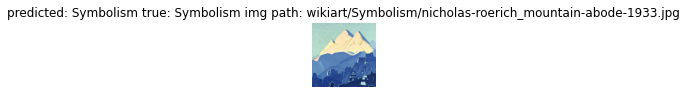

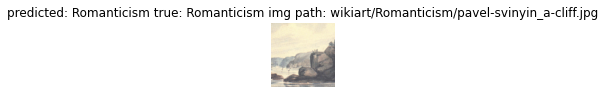

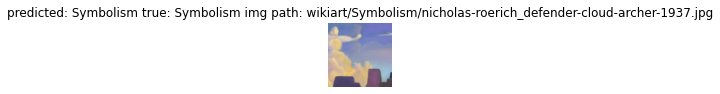

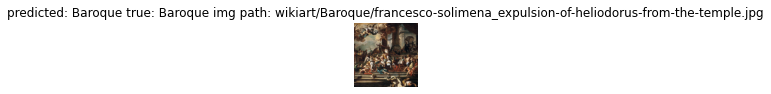

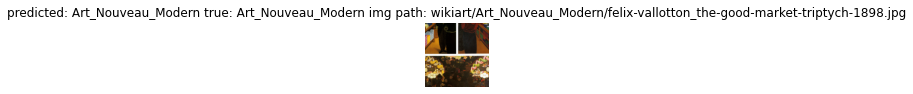

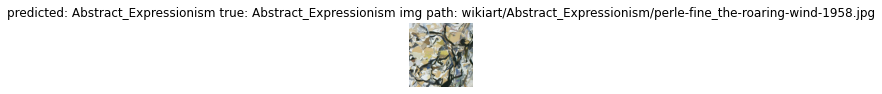

In [26]:
visualize_model(model_ft)

# 3. Optimization

In [ ]:
torch.save(model_ft.state_dict(), '/content/gdrive/MyDrive/Work/BlogData/best_epoch13.pt')

In [27]:
scripted_model = torch.jit.script(model_ft)
print(scripted_model.code)
scripted_model.save('/content/gdrive/MyDrive/Work/BlogData/scripted_best_epoch21.pt')

def forward(self,
    x: Tensor) -> Tensor:
  return (self)._forward_impl(x, )



In [2]:
# Based on tutorials
# https://www.google.com/search?client=safari&rls=en&q=pytorch+tutorial+optimise+inference+speed&ie=UTF-8&oe=UTF-8
# https://pytorch.org/tutorials/recipes/mobile_perf.html?highlight=mobile
# 
!pip install torch torchvision timm pandas requests

In [ ]:

# example on how to convert to torchscript in the following link
# https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html
# Steps
#   - Tracing
#   - 

#traced_model = torch.jit.trace(model_ft, example_inputs=wikiart_dataset[0])
#print(traced_model.code)
scripted_model = torch.jit.script(model_ft)
print(scripted_model.code)
scripted_model.save('/content/gdrive/MyDrive/Work/BlogData/scripted_best_epoch13.pt')
# Benefits of tracing
#   - Many requests can be processed at the same time (we can run in inference mode on several different )


# TODO Tracing vs Scripting? Major differences?

def forward(self,
    x: Tensor) -> Tensor:
  return (self)._forward_impl(x, )



In [6]:
loaded = torch.jit.load('/content/gdrive/MyDrive/Work/BlogData/scripted_best_epoch21.pt')

In [7]:
inputs, labels, img_paths = next(iter(dataloaders['val']))
loaded.eval()
inputs = inputs.to(device)
outputs = loaded(inputs)
_, preds = torch.max(outputs, 1)
print(preds, labels)

NameError: ignored

# 4. Experimentation

In [30]:
!pip install mlflow

     |████████████████████████████████| 15.5 MB 573 kB/s 
     |████████████████████████████████| 180 kB 50.0 MB/s 
     |████████████████████████████████| 79 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 48.8 MB/s 
     |████████████████████████████████| 1.1 MB 46.0 MB/s 
     |████████████████████████████████| 146 kB 48.6 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=09f4175f535faf8f6c235bfc033f15b53145609d38c273fba78ca8c580e79c05
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.16.2-py3-none-any.whl size=106811 sha256=f09310ac19f4ebd10ad7942c200b32a39ba8b7fc20ee4911e0719a52aee40c0

In [9]:
loaded

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
    )
    (1): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)

In [11]:
!pip install pyngrok --quiet

import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "23Mgu4RXeFXfuRAFfqlpiIGZqox_2UKEqW6Khj557j1cFNTCc"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://c28b-35-234-12-87.ngrok.io


In [24]:
ngrok.kill()

ngrok.disconnect(ngrok_tunnel.public_url)

# 5. Serving

In [12]:
!pip install torchserve torch-model-archiver torch-workflow-archiver

     |████████████████████████████████| 19.6 MB 1.3 MB/s 


In [13]:
%%bash
# install torchserve
cd /content
git clone https://github.com/pytorch/serve.git
cd serve
python ./ts_scripts/install_dependencies.py --cuda=cu102
# we need to run commands from the parent dir
cd ..
mkdir model_store

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [716 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease 

Cloning into 'serve'...
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
sh: 1: conda: not found
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you h

In [20]:
ls

datasets/  gdrive/  mlruns/  model_store/  sample_data/  serve/


In [18]:
import json
with open('/content/gdrive/MyDrive/Work/BlogData/index_to_name.json', 'w') as j_file:
    json.dump(style_class, j_file)

In [19]:
%%bash
# insert model name here
# /content/gdrive/MyDrive/Work/BlogData/best_epoch12.pt
# MAR takes in a model in torchscript format

torch-model-archiver --model-name resnet18 --version 1.0 --serialized-file /content/gdrive/MyDrive/Work/BlogData/scripted_best_epoch13.pt --export-path model_store --extra-files /content/gdrive/MyDrive/Work/BlogData/index_to_name.json --handler image_classifier


In [32]:
!keytool -genkey -keyalg RSA -alias ts -keystore keystore.p12 -storepass changeit -storetype PKCS12 -validity 3600 -keysize 2048 -dname "CN=www.MY_TS.com, OU=Cloud Service, O=model server, L=Palo Alto, ST=California, C=US"

In [31]:
!torchserve --start --ncs --model-store model_store --models resnet18.mar

Removing orphan pid file.
2022-01-07T10:36:40,896 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2022-01-07T10:36:41,032 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.5.2
TS Home: /usr/local/lib/python3.7/dist-packages
Current directory: /content
Temp directory: /tmp
Number of GPUs: 1
Number of CPUs: 2
Max heap size: 3248 M
Python executable: /usr/bin/python3
Config file: N/A
Inference address: http://127.0.0.1:8080
Management address: http://127.0.0.1:8081
Metrics address: http://127.0.0.1:8082
Model Store: /content/model_store
Initial Models: resnet18.mar
Log dir: /content/logs
Metrics dir: /content/logs
Netty threads: 0
Netty client threads: 0
Default workers per model: 1
Blacklist Regex: N/A
Maximum Response Size: 6553500
Maximum Request Size: 6553500
Limit Maximum Image Pixels: true
Prefer direct buffer: false
Allowed Urls: [file://.*|http(s)?://.*]
Custom python dependency for model allowed: false
Metrics repo

In [26]:
!torchserve --stop

TorchServe already stopped.


In [27]:
!openssl req -x509 -nodes -days 365 -newkey rsa:2048 -keyout mykey.key -out mycert.pem

Can't load /root/.rnd into RNG
139921270642560:error:2406F079:random number generator:RAND_load_file:Cannot open file:../crypto/rand/randfile.c:88:Filename=/root/.rnd
Generating a RSA private key
..+++++
....+++++
writing new private key to 'mykey.key'
-----
You are about to be asked to enter information that will be incorporated
into your certificate request.
What you are about to enter is what is called a Distinguished Name or a DN.
There are quite a few fields but you can leave some blank
For some fields there will be a default value,
If you enter '.', the field will be left blank.
-----
Country Name (2 letter code) [AU]:CH
State or Province Name (full name) [Some-State]:Basel
Locality Name (eg, city) []:Basel
Organization Name (eg, company) [Internet Widgits Pty Ltd]:
Organizational Unit Name (eg, section) []:
Common Name (e.g. server FQDN or YOUR name) []:ANTONIO
Email Address []:antoniomorais.nn@gmail.com
